In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

C:\Users\hp\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading Data

In [2]:
%matplotlib inline

In [3]:
# !pip install openpyxl

In [4]:
df = pd.read_excel('../data/Prices.xlsx', sheet_name='Daily', skiprows=8, usecols='D:E', index_col='Name')
df.index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

In [5]:
df.head()

,US dollar
Name,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15


In [6]:
df.index # already a datetime index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

### Visualization and Analytics

             US dollar
Name                  
1978-12-31  226.000000
1979-01-31  227.215217
1979-02-28  245.670000
1979-03-31  242.047727
1979-04-30  238.664286


<AxesSubplot:xlabel='Name'>

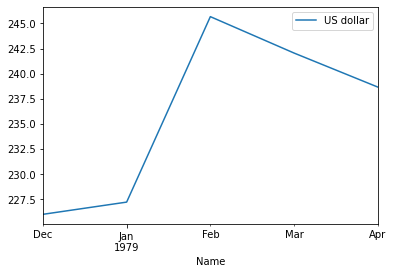

In [7]:
# Mean value at the end of month
print(df.resample(rule='M').mean().head())
df.resample(rule='M').mean().head().plot() # 1978 Dec - 1979 April

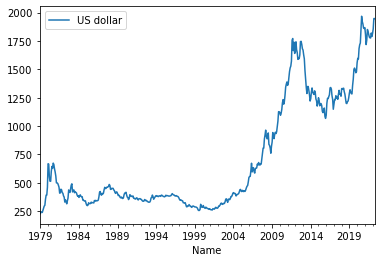

In [8]:
df.resample(rule='M').mean().plot(); # 1978 Dec-Curr

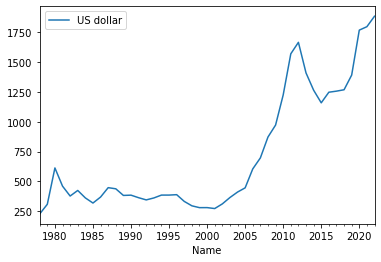

In [9]:
df.resample(rule='AS').mean().plot(); # year start resample, less noise

In [10]:
df.rolling(window=30).mean()[30:] # rolling average of every month

,US dollar
Name,
1979-02-09,230.735000
1979-02-12,231.343333
1979-02-13,231.803333
1979-02-14,232.538333
1979-02-15,233.358333
...,...
2022-04-11,1945.310000
2022-04-12,1946.605000
2022-04-13,1948.213333


<AxesSubplot:xlabel='Name'>

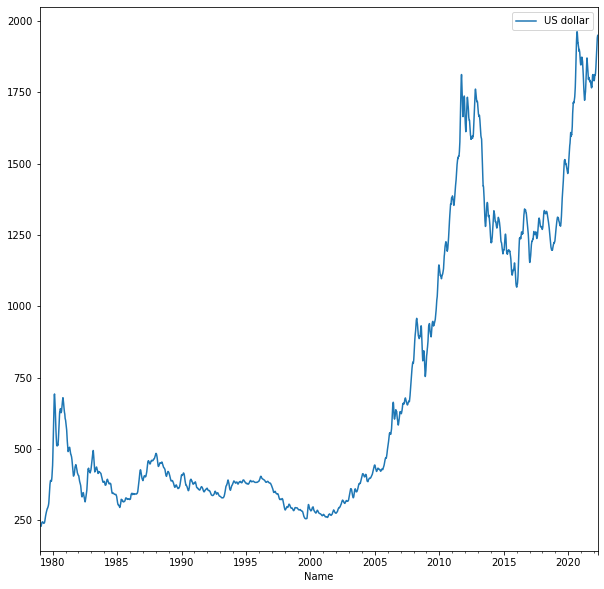

In [11]:
df.rolling(window=30).mean().plot(figsize=(10,10)) # rolling average of every month

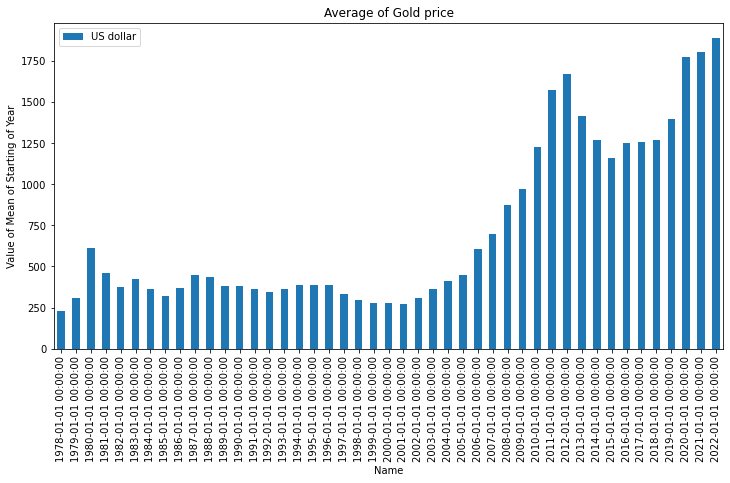

In [12]:
ax = df.resample(rule='AS').mean().plot.bar(figsize=(12,6))
ax.set(title='Average of Gold price', ylabel='Value of Mean of Starting of Year');

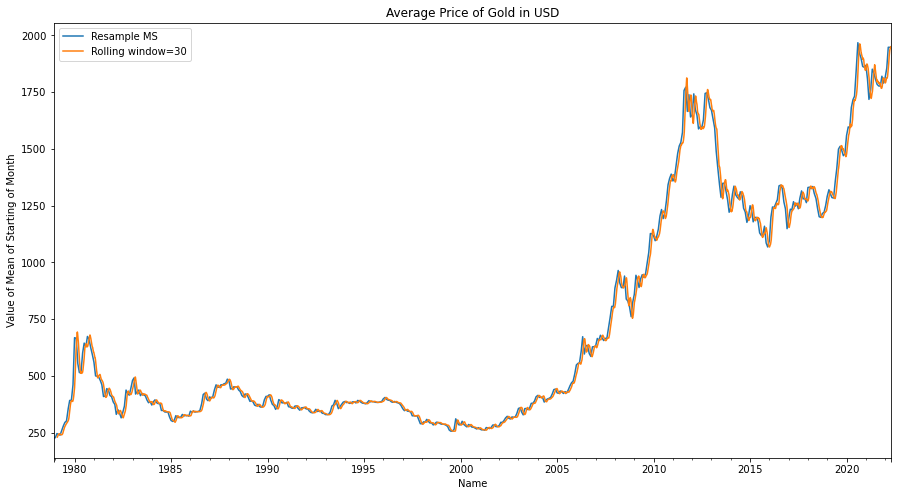

In [13]:
ax = df['US dollar'].resample(rule='M').mean().plot(figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

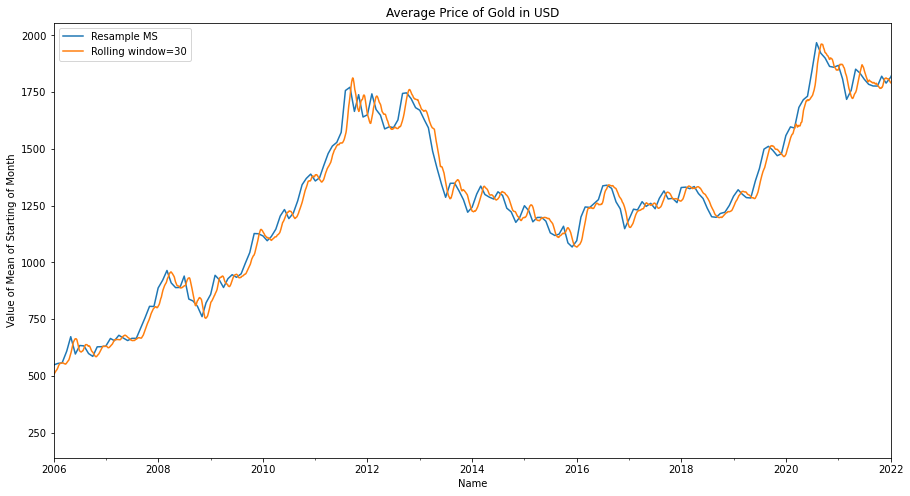

In [14]:
# rolling mean from 2006, till 2020 to check the spike and decrease.

ax = df['US dollar'].resample(rule='M').mean().plot(xlim=['2006-01-01','2022-01-01'], figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(xlim=['2006-01-01','2022-01-01'],label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

## Models
* ARIMA
* FBProphet
* Bi-directional LSTM
* Pycaret

In [15]:
# !pip install fbprophet

In [16]:
prophet_model = Prophet(interval_width=0.95)

In [17]:
# renaming for fbprophet
df.rename_axis('ds', inplace=True)
df.rename(columns={'US dollar':'y'}, inplace=True)
df.reset_index(inplace=True) 

df.head()

,ds,y
0,1978-12-29,226.00
1,1979-01-01,226.00
2,1979-01-02,226.80
3,1979-01-03,218.60
4,1979-01-04,223.15


In [18]:
prophet_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### predictions

In [19]:
future_dataset= prophet_model.make_future_dataframe(periods=15, freq='y') # 15 YEARS OF DATA

In [20]:
future_dataset.tail()

,ds
11306,2032-12-31
11307,2033-12-31
11308,2034-12-31
11309,2035-12-31
11310,2036-12-31


In [21]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1978-12-29,198.190717,37.649574,350.666259
1,1979-01-01,202.610300,34.265326,375.458218
2,1979-01-02,204.201136,35.816410,362.521922
3,1979-01-03,205.976840,42.288406,362.155616
4,1979-01-04,207.627541,52.584523,371.711477


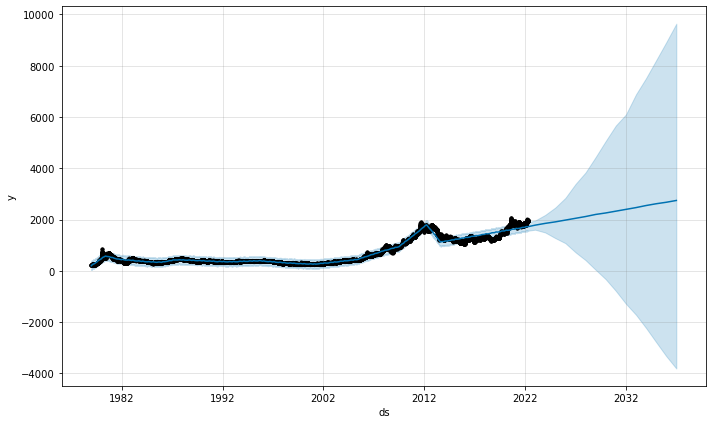

In [22]:
prophet_model.plot(pred);

In [23]:
date_pred='2030-12-12'

In [24]:
date = pd.DataFrame({'ds':pd.date_range(start=date_pred, end=date_pred)})

date.head()

,ds
0,2030-12-12


In [25]:
pred = prophet_model.predict(date)

In [26]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2030-12-12,2330.335897,-818.836881,5571.555966,-864.922215,5654.791374,-9.169629,-9.169629,-9.169629,-3.274349,-3.274349,-3.274349,-5.89528,-5.89528,-5.89528,0.0,0.0,0.0,2321.166269


#### saving

In [27]:
import pickle
with open('../models/fbprophet.pckl', 'wb') as fout:
    pickle.dump(prophet_model, fout)